This is a simple simulation of spurious associations based on the book [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) chapter 5.1.

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

The purpose of this simulation is to show that with a mutiple regression model it's possible to spot spurious associations.

Below `x_real` which is a truly causal predictor that influences both `y` and `x_spur`.

In [2]:
SAMP_SIZE = 10000 # size of sample

x_real = stats.norm.rvs(size=SAMP_SIZE)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

d = {'x_real': x_real,
    'x_spur': x_spur,
    'y': y}
df = pd.DataFrame(data=d)
df.head()

,x_real,x_spur,y
0,0.573234,0.383901,-0.161503
1,-0.002760,-0.234374,0.349927
2,1.231456,1.316195,2.822013
3,-0.512771,0.024104,-1.722948
4,1.043257,-0.478272,-1.287780


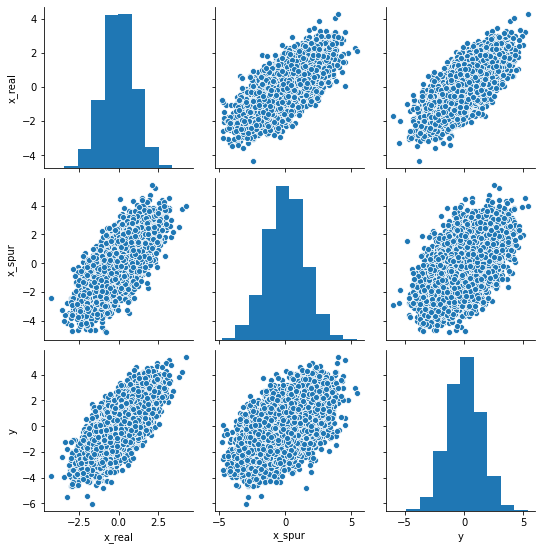

In [3]:
sns.pairplot(data=df)

We can notice by the plot above that `x_real` and `x_spur` seem be quite correlated to `y`.

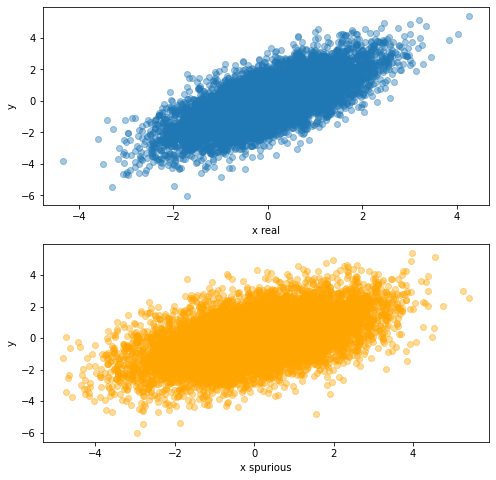

In [4]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

ax1.plot(x_real, y, 'o', alpha=0.4)
ax1.set_xlabel('x real')
ax1.set_ylabel('y')
ax1
ax2.plot(x_spur, y, 'o', color='orange', alpha=0.4)
ax2.set_xlabel('x spurious')
ax2.set_ylabel('y')
plt.show()

In [5]:
with pm.Model() as spur_t:
    a = pm.Normal('a', 0, 1)
    b = pm.Normal('b', 0, 1)
    c = pm.Normal('c', 0, 1)
    mu = pm.Deterministic('mu', a + b*x_real + c*x_spur)
    sigma = pm.Exponential('sigma', 1)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    
    spur_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1786.36draws/s]
The acceptance probability does not match the target. It is 0.8795620905257736, but should be close to 0.8. Try to increase the number of tuning steps.


In [6]:
varnames = ['~mu']
az.summary(spur_trace, varnames, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.00,0.01,-0.02,0.02
b,1.01,0.01,0.99,1.04
c,0.00,0.01,-0.02,0.02
sigma,0.99,0.01,0.98,1.00


By using a mutiple regression we can spot that `x_spur`, is a spurious association to the variable `y` as its coeficient `c` is close to `0`.

The DAG for this case is:

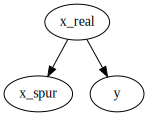

In [7]:
assoc = CausalGraphicalModel(
    nodes=["x_real", "x_spur", "y"], edges=[("x_real", "x_spur"), ("x_real", "y")]
)

assoc.draw()